# Steps to follow in order to get the selected interpration by using LLama:
1. run all data train and test with the new prompt with llama
2. interpretations = calculate_prior_probability(interpretations, w_llm=0.5, w_bscore =0.7)
3. interpretations = calculate_fit_quality(interpretations,w_rwp=1, w_score=0.5)
4. interpretations = calculate_posterior_probability_of_interpretation(interpretations)


Make sure LLM_interpretation_likelihood is updated with the LLama's answer & you store the final prior and fit_quality and posterior with different name, do not overwrite the excisting one. Then we can compare the selected interpretation(higher prob) by using Chatgpt vs LLama vs "lowset rwp valus"

In [64]:
def calculate_prior_probability(interpretations, w_llm=1, w_bscore=1):
    # Update each interpretation with a new field "prior_probability"
    for interpretation_name, interpretation in interpretations.items():
        if interpretation_name != "Synth_Conditions":
            interpretation["prior_probability_llama"] = (
           (interpretation["LLM_interpretation_likelihood_llama"]*w_llm + interpretation["balance_score"]*w_bscore)/(w_llm + w_bscore))     
        else: continue 
        
    return interpretations

In [65]:
def calculate_fit_quality(interpretations, w_rwp=1, w_score=1):
    for key, interpretation in interpretations.items():
        if key != "Synth_Conditions":
            interpretation["fit_quality"] = (interpretation["normalized_rwp"]*w_rwp + interpretation["normalized_score"]*w_score) / (w_rwp + w_score)
    return interpretations

In [66]:
def calculate_posterior_probability_of_interpretation(interpretations):
    """
    Calculate the posterior probabilities P(In | S) for all interpretations
    using balance_score and interpretation_importance.
    
    Parameters:
        interpretations (dict or list): A dictionary of interpretations or 
                                        a list containing a single dictionary.

    Returns:
        dict: Updated interpretations with added "posterior_probability" field.
    """
    # Extract dictionary if interpretations is a list
    if isinstance(interpretations, list) and len(interpretations) == 1:
        interpretations = interpretations[0]  # Extract the dictionary

    if not isinstance(interpretations, dict):
        raise ValueError("Interpretations should be a dictionary or a list containing a dictionary.")

     # Step 1: Compute unnormalized posterior = prior * fit_quality
    joint_probabilities = {}
    for name, interp in interpretations.items():
        if name != "Synth_Conditions":
            joint = interp["prior_probability_llama"] * interp["fit_quality"]
            interpretations[name]["unnormalized_posterior_llama"] = joint
            joint_probabilities[name] = joint

    # Step 2: Normalize to get posterior_probability
    total_joint = sum(joint_probabilities.values())
    for name in interpretations:
        if name != "Synth_Conditions":
            if total_joint > 0:
                interpretations[name]["posterior_probability_llama"] = (
                interpretations[name]["unnormalized_posterior_llama"] / total_joint
            )
            else:
                interpretations[name]["posterior_probability_llama"] = 0.0

    return interpretations  

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

def load_json(file_path): # Load JSON Data
    if os.path.exists(file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            try:
                return json.load(f)
            except json.JSONDecodeError:
                print("JSON decode error — file is empty or malformed.")
                return {}
    else:
        return {}  # Return empty dict if file doesn't exist


def update_json(data, key, value): # Modify/Add Data
    data[key] = value
    return data

def save_json(file_path, data): # Save JSON Data
    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

In [68]:
file_path = "Data/prompt3/interpretations_llm_v1_REMADE_llama4.json"
json_file = load_json(file_path)
for sample in json_file:
    tester = False
    for interpret in json_file[sample]:
        if interpret != "Synth_Conditions":
            if not "LLM_interpretation_likelihood_llama" in json_file[sample][interpret]:
                tester = True
    if tester == False:        
        interpretations = json_file[sample]
        interpretations = calculate_prior_probability(interpretations, w_llm=0.5, w_bscore =0.7)
        interpretations = calculate_fit_quality(interpretations,w_rwp=1, w_score=0.5)
        interpretations = calculate_posterior_probability_of_interpretation(interpretations)
        json_file[sample] = interpretations

save_json(file_path,json_file)

In [69]:
json_file = load_json(file_path)
sample_choice = {}
for sample in json_file:
    sample_choice[sample] = {}
    llama_probs = []
    chat_probs = []
    for interpretation in json_file[sample]:
        if interpretation != "Synth_Conditions":
            if "unnormalized_posterior_llama" in json_file[sample][interpretation]:
                llama_probs.append((interpretation,json_file[sample][interpretation]["unnormalized_posterior_llama"]))
                chat_probs.append((interpretation,json_file[sample][interpretation]["unnormalized_posterior"]))
            else:
                chat_probs.append((interpretation,json_file[sample][interpretation]["unnormalized_posterior"]))
    if llama_probs:
        llama_choice = max(llama_probs, key=lambda x: x[1])[0]
    else:
        llama_choice = "I_1 (oops)"
    chat_choice = max(chat_probs, key=lambda x: x[1])[0]
    sample_choice[sample]["llama_choice"] = llama_choice
    sample_choice[sample]["chat_choice"] = chat_choice

for sample, choices in sample_choice.items():
    print(f"{sample}")
    print(f"Chat GPT: {choices["chat_choice"]}")
    print(f"Llama: {choices["llama_choice"]}")   

PG_1048_1
Chat GPT: I_3
Llama: I_3
ARR_39
Chat GPT: I_1
Llama: I_1
TRI_62
Chat GPT: I_7
Llama: I_7
TRI_84
Chat GPT: I_2
Llama: I_1
TRI_80
Chat GPT: I_1
Llama: I_1
PG_0849_1
Chat GPT: I_2
Llama: I_2
TRI_81
Chat GPT: I_2
Llama: I_1
TRI_90
Chat GPT: I_1
Llama: I_3
TRI_106
Chat GPT: I_2
Llama: I_1
TRI_114
Chat GPT: I_1
Llama: I_4
TRI_183
Chat GPT: I_4
Llama: I_4
TRI_41
Chat GPT: I_2
Llama: I_1
TRI_87
Chat GPT: I_5
Llama: I_5
ARR_46
Chat GPT: I_3
Llama: I_3
TRI_105
Chat GPT: I_1
Llama: I_1


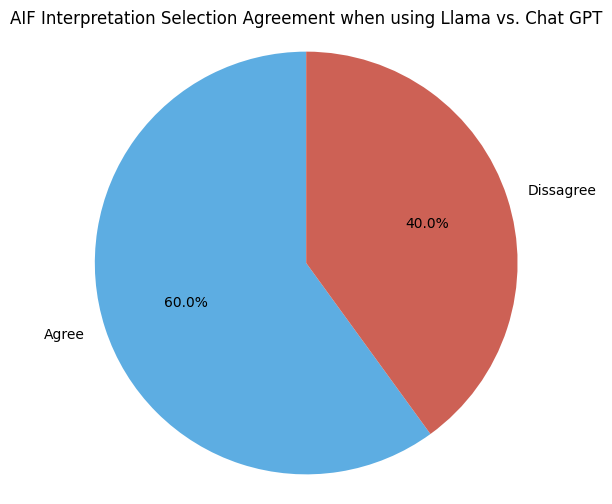

In [70]:
agree = 0 
disagree = 0 
for sample, choices in sample_choice.items():
    if choices["chat_choice"] == choices["llama_choice"]:
        agree += 1
    else: disagree += 1

values = [agree, disagree]  
labels = ['Agree', 'Dissagree']  # Replace with your labels
colors = ['#5dade2', '#cd6155']  # Optional: customize colors

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title(f'AIF Interpretation Selection Agreement when using Llama vs. Chat GPT')
plt.axis('equal')  # Ensures pie is a circle
plt.show()

In [71]:
for sample, choices in sample_choice.items():
    if choices["chat_choice"] == choices["llama_choice"]:
        print(f"{sample}: Agree")
    else: print(f"{sample}: Disagree ({choices["chat_choice"]},{choices["llama_choice"]})")

PG_1048_1: Agree
ARR_39: Agree
TRI_62: Agree
TRI_84: Disagree (I_2,I_1)
TRI_80: Agree
PG_0849_1: Agree
TRI_81: Disagree (I_2,I_1)
TRI_90: Disagree (I_1,I_3)
TRI_106: Disagree (I_2,I_1)
TRI_114: Disagree (I_1,I_4)
TRI_183: Agree
TRI_41: Disagree (I_2,I_1)
TRI_87: Agree
ARR_46: Agree
TRI_105: Agree


In [72]:
def flag_interpretation_trustworthiness_llama(interpretations: dict) -> dict:
    """
    Adds a 'trustworthy' field to each interpretation in the dictionary based on custom flagging rules.

    Parameters:
        interpretations (dict): A dictionary of interpretation entries (I_1, I_2, ...) where each entry is a dictionary of properties.

    Returns:
        dict: The updated dictionary with a new key 'trustworthy' added to each interpretation.
    """

    for key, interp in interpretations.items():
        if key != "Synth_Conditions":
            balance_score = interp.get("balance_score", 1.0)
            llm = interp.get("LLM_interpretation_likelihood", 1.0)
            signal_above_bkg_score =interp.get("signal_above_bkg_score", 0.0)
            bkg_overshoot_score =interp.get("bkg_overshoot_score", 0.0)
            peak_match_score = interp.get("normalized_score",1.0)

        # Apply your custom flags
        flag1 = llm <= 0.4
        if signal_above_bkg_score !=0.0:
            flag2 = signal_above_bkg_score < 9000
        else:
            flag2 = False
        if bkg_overshoot_score !=0.0:
            flag3 = bkg_overshoot_score > 1200
        else:
            flag3 = False

        if bkg_overshoot_score !=0.0 and signal_above_bkg_score !=0.0:
            flag4 = signal_above_bkg_score/bkg_overshoot_score < 15
        else:
            flag4 = False

        flag5 = balance_score < 0.6
        # flag6 = peak_match_score < 0.6

        # If any flag is True, it's not trustworthy
        interp["trustworthy"] = not (flag1 or flag2 or flag3 or flag4 or flag5 ) #or flag6)

    return interpretations